In [26]:
import numpy as np 
import pandas as pd 
import os
import itertools

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, merge, UpSampling2D, Cropping2D, ZeroPadding2D, Reshape, core, Convolution2D, Conv2DTranspose
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import optimizers
from keras import backend as K
from keras.optimizers import SGD
from keras.layers.merge import concatenate
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import load_img

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import preprocess
from model_00 import get_model
import pickle
import splitdata

In [20]:
with open(os.path.join(splitdata.d_data, splitdata.f_train), "rb") as file:
    files = pickle.load(file)
if not files_train:
    raise Exception("Could not load training files!")

In [21]:
np.random.shuffle(files)
n_valid = int(np.ceil(len(files) * 0.15))
files_train = files[n_valid:]
files_valid = files[:n_valid]

In [25]:
def augment_imgarr(x, i):
    if i % 4 == 0:
        return np.rot90(x, k=i)
    if i == 4:
        return np.flip(x, 0)
    if i == 5:
        return np.flip(x, 1)
    else:
        return np.transpose(x, axes=(1, 0, 2))

In [44]:
def calc_weights(y):
    n_ones = np.sum(y)
    n_total = y.shape[1]**2
    w_ones = 1 - n_ones / n_total
    w_zeros = 1 - w_ones
    w = y * (w_ones - w_zeros) + w_zeros
    return w

def dataGenerator(files, batches=1, weights=False):
    files = itertools.cycle(files)
    while True:
        X = np.zeros((batches, 2084, 2084, 3), dtype=np.float32)
        Y = np.zeros((batches, 2084, 2084, 1), dtype=np.float32)
        if weights:
            W = np.zeros((batches, 2084, 2084, 1), dtype=np.float32)
        for i in range(batches):
            f_png, f_csv, _ = next(files)
            x = np.array(load_img(f_png))
            y = preprocess.get_ndarray_from_csv(f_csv, X[i].shape[0], X[i].shape[1])
            x = x / 255
            idx = np.random.randint(0, 7)
            X[i] = augment_imgarr(x, idx)
            y = augment_imgarr(y, idx)
            Y[i] = y
            if weights:
                W[i] = calc_weights(y)
        if weights:
            yield X, Y, W
        else:
            yield X, Y

(2, 2084, 2084, 3) (2, 2084, 2084, 1)


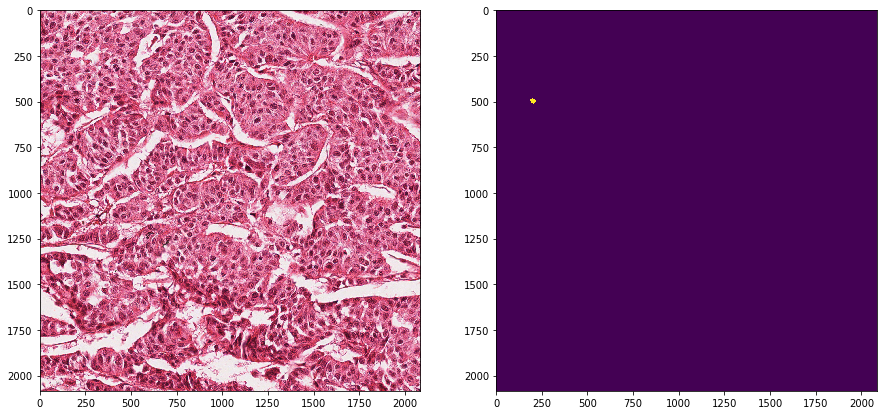

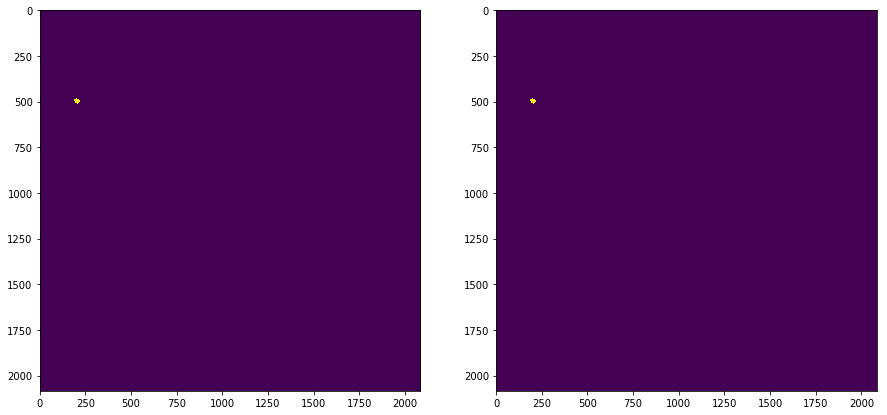

(2, 2084, 2084, 3) (2, 2084, 2084, 1)


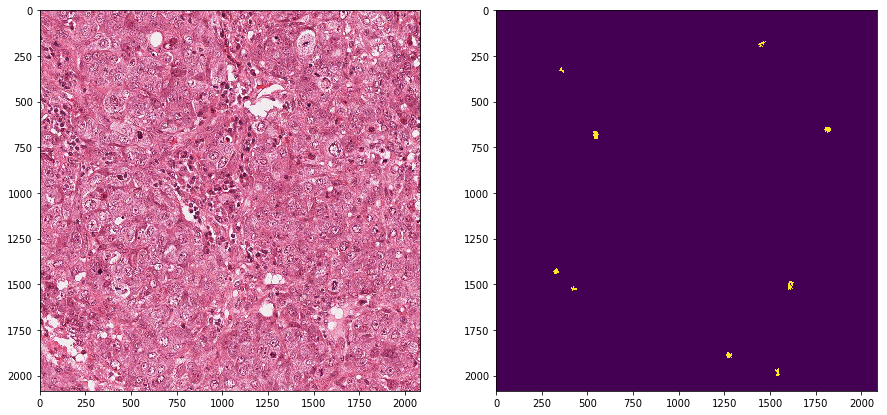

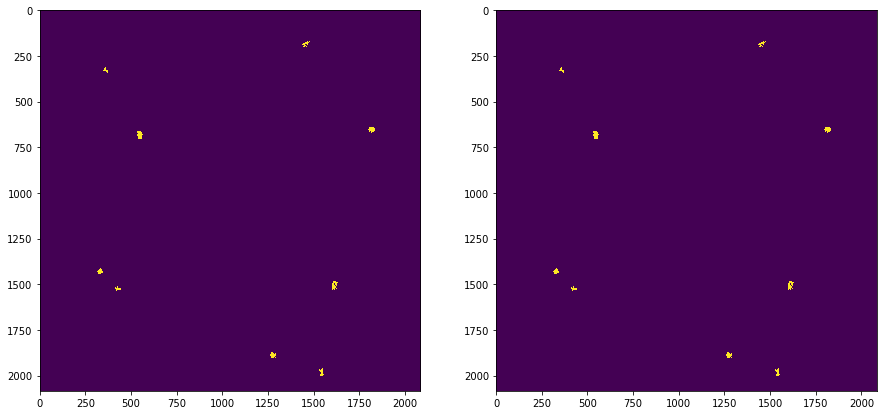

In [47]:
dg = dataGenerator(files_train, batches=2, weights=True)
for i in range(2):
    X, Y, W = next(dg)
    print(X.shape, Y.shape)
    preprocess.show_ndimg(X[0], Y[0])
    preprocess.show_ndimg(Y[0], W[0])
    

In [55]:
model = get_model(n_kernels=4, img_height=2084, img_width=2084)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2084, 2084, 3 0                                            
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 2084, 2084, 4 112         input_4[0][0]                    
__________________________________________________________________________________________________
conv_2_2 (Conv2D)               (None, 2084, 2084, 4 148         conv_1_1[0][0]                   
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 1042, 1042, 4 0           conv_2_2[0][0]                   
__________________________________________________________________________________________________
conv2_1 (C

In [56]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.98, nesterov=True),
              metrics=['accuracy'])

In [59]:
callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=1),
             ModelCheckpoint("model00.h5", monitor='val_loss', save_best_only=True, verbose=1)]

In [57]:
train_generator = dataGenerator(files_train, batches=1, weights=True)
valid_generator = dataGenerator(files_valid, batches=1, weights=True)

In [60]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=5,
                    epochs=2,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator,
                    validation_steps=5,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False)

Epoch 1/2


ValueError: Found a sample_weight array with shape (1, 2084, 2084, 1). In order to use timestep-wise sample weights, you should specify sample_weight_mode="temporal" in compile(). If you just mean to use sample-wise weights, make sure your sample_weight array is 1D.